<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative05102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações 

In [36]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer

from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [37]:
print(tf.__version__)

2.6.0


In [38]:
# Instalar Tensorflow
#!pip install tensorflow==2.6.0

# Instalar Keras
!pip install keras --upgrade

In [39]:
# Caso precise, remover os diretorios

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
!rm -rf geological_similarity

# **Coleta de dados do Kaglle**

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# **###  Download dos dados / descompactando os dados**

In [40]:
#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity    

 80% 27.0M/33.6M [00:00<00:00, 117MB/s]
100% 33.6M/33.6M [00:00<00:00, 130MB/s]


## ** Criação da estrutura e leitura de diretórios **

In [41]:
dataset_path = 'geological_similarity'
print("[INFO] Carregando as Imagens...")
imagePaths = list(paths.list_images(dataset_path))
dados = []
labels = []

[INFO] Carregando as Imagens...


In [42]:
# atravessa os caminhos da imagem
for imagePath in imagePaths:
    # extrai o rótulo da classe do nome do arquivo
    label = imagePath.split(os.path.sep)[-2]
    

# carrega a imagem, troca os canais de cor e redimensiona para ser um 32x32 pixels, independentemente da proporção
    image = cv.imread(imagePath)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (32, 32))
    
# atualiza as listas de dados e rótulos, respectivamente
    dados.append(image)
    labels.append(label)
print("labels: ", np.unique(labels))

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


In [43]:
# converter os dados e rótulos em matrizes NumPy enquanto dimensiona o pixel
# intensidades na faixa [0, 255]

dados = np.array(dados) / 255.0
labels = np.array(labels)

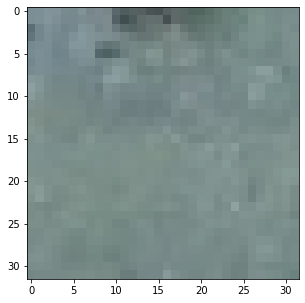

In [44]:
plt.figure(figsize=(5, 5))
plt.imshow(dados[labels=='andesite'][0])
plt.show()

In [ ]:
# particionar os dados em divisões de treinamento e teste usando 80% dos dados para treinamento e os 20% restantes para teste

#(X_train, X_test, y_train, y_test) = train_test_split(dados, labels, test_size=0.2, stratify=labels, random_state=42)

#  Conhecendo os dados de imagem

In [45]:
from numpy import asarray
image = Image.open("geological_similarity/gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

In [ ]:
### 1 - Analisando os dados ausentes ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

NameError: ignored

In [ ]:
#! pip install pandas-profiling==2.8.0
#from pandas_profiling import ProfileReport
#ProfileReport (data_df)

# **Explorando os dados**


# **Type: Data Augumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [46]:
IMG_SHAPE = 32
BATCH_SIZE = 1024

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [47]:
# Dados de Treino e Validação

datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)


In [48]:
train_generator = datagen.flow_from_directory(r"./geological_similarity/",
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    shuffle=True, 
                                                    target_size = (IMG_SHAPE,IMG_SHAPE),
                                                    subset='training')


validation_generator = datagen_val.flow_from_directory(r"./geological_similarity/",
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    shuffle=True, 
                                                    target_size = (IMG_SHAPE,IMG_SHAPE),
                                                    subset='validation')

Found 23999 images belonging to 6 classes.
Found 5999 images belonging to 6 classes.


In [49]:
# Dados de Teste

datagen_test = ImageDataGenerator (rescale=1./255, 
                                  rotation_range = 40)

test_generator = datagen_test.flow_from_directory(r"./geological_similarity/",
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    shuffle=False, 
                                                    target_size = (IMG_SHAPE,IMG_SHAPE))
                                                    #subset='validation')


Found 29998 images belonging to 6 classes.


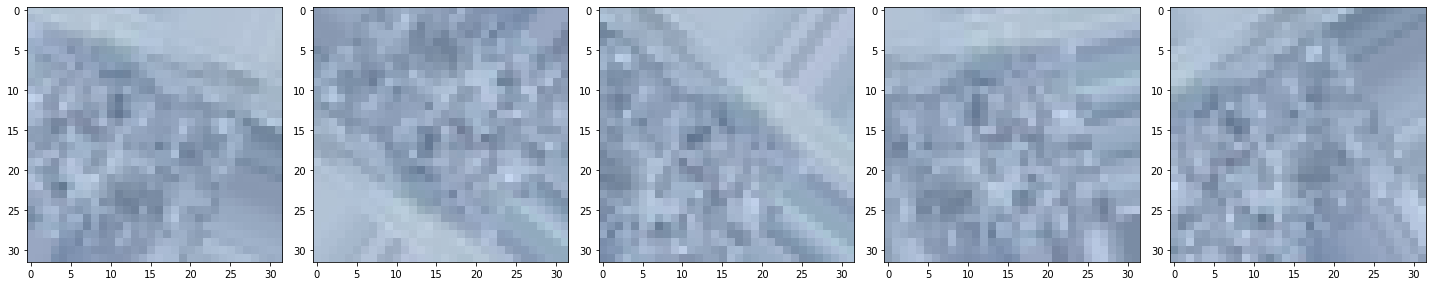

In [50]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Criando o Dataframe em dados de treino, validação e teste**

In [51]:
class_dict=test_generator.class_indices
labels= test_generator.labels
file_names= test_generator.filenames 

class_dict

{'andesite': 0,
 'gneiss': 1,
 'marble': 2,
 'quartzite': 3,
 'rhyolite': 4,
 'schist': 5}

In [52]:
train_generator.class_indices.keys()

dict_keys(['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist'])

In [53]:
X_train, y_train = next(train_generator)
X_val, y_val = next(validation_generator)
X_test, y_test = next(test_generator)

print(X_test.shape)

(1024, 32, 32, 3)


# **Criar o modelo**

In [54]:
num_classes = 6

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32,32,3)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
   
])

# **Compilando o Modelo**

In [55]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])
model.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [56]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        #save_weights_only=False,
        #mode='auto',
        #period=1,
    ),

]

# **Avaliar o modelo**

In [57]:
epochs=200
history = model.fit(X_train,y_train,
                               epochs=epochs,
                               verbose=1,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               steps_per_epoch = 23999/64,
                               workers=4,
                               use_multiprocessing=True,
                               #validation_steps = 5999/256,
                               validation_data=(X_val,y_val))

Epoch 1/200
374/374 [==============================] - 5s 11ms/step - loss: 1.6763 - accuracy: 0.3134 - val_loss: 1.3518 - val_accuracy: 0.5703

Epoch 00001: val_accuracy improved from -inf to 0.57031, saving model to best_model.h5
Epoch 2/200
374/374 [==============================] - 4s 11ms/step - loss: 1.0721 - accuracy: 0.5485 - val_loss: 0.8401 - val_accuracy: 0.7227

Epoch 00002: val_accuracy improved from 0.57031 to 0.72266, saving model to best_model.h5
Epoch 3/200
374/374 [==============================] - 4s 11ms/step - loss: 0.8611 - accuracy: 0.6251 - val_loss: 0.7855 - val_accuracy: 0.6787

Epoch 00003: val_accuracy did not improve from 0.72266
Epoch 4/200
374/374 [==============================] - 4s 11ms/step - loss: 0.6682 - accuracy: 0.7311 - val_loss: 0.5038 - val_accuracy: 0.8584

Epoch 00004: val_accuracy improved from 0.72266 to 0.85840, saving model to best_model.h5
Epoch 5/200
374/374 [==============================] - 4s 11ms/step - loss: 0.5564 - accuracy: 0.7

**Deixe-nos representar graficamente a Precisão do treinamento versus perda para obter uma melhor compreensão do treinamento do modelo.**

Text(0.5, 1.0, 'Train - Accuracy')

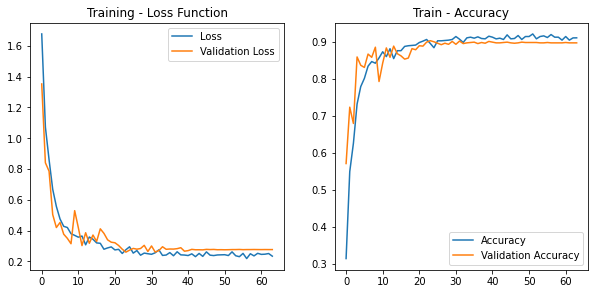

In [58]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


# **Vamos traçar a precisão do treinamento e da validação, bem como a perda.** 

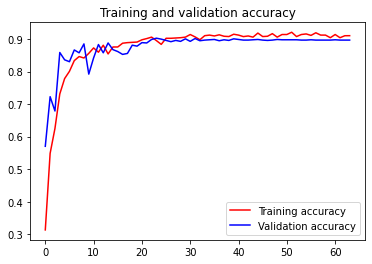

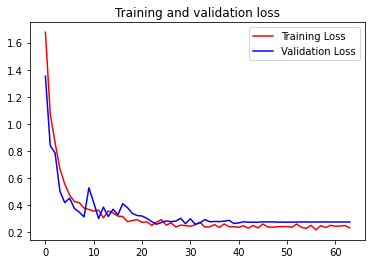

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Avaliar acurácia  do Modelo**

In [60]:
model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc= model.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_acc))

32/32 [==============================] - 1s 14ms/step - loss: 0.5398 - accuracy: 0.8252
validation_accuracy: 0.8251953125


# **Predição**

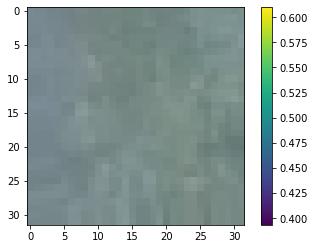

In [61]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

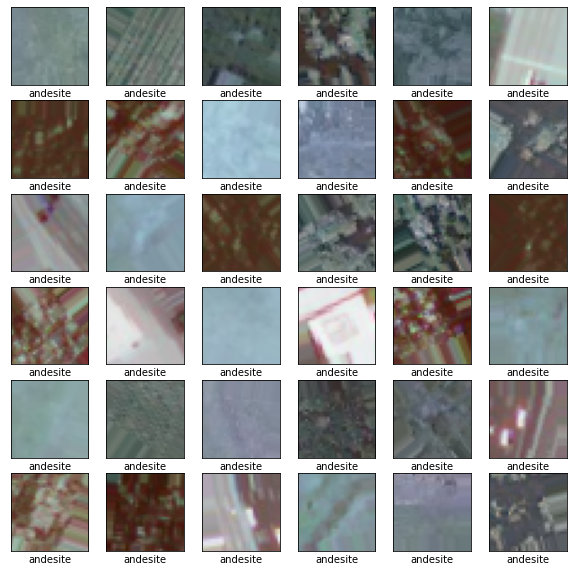

In [62]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    label_index = labels[i]
    plt.xlabel(class_names[label_index])
plt.show()
   

In [63]:
pred = model.predict(X_test)
print("Prediction_accuracy: " + str(pred))

Prediction_accuracy: [[9.33474481e-01 7.35934418e-06 1.88042257e-08 6.07799739e-02
  3.88339069e-03 1.85484556e-03]
 [8.83261673e-03 1.01406767e-03 1.28141767e-03 8.73157842e-06
  8.57602835e-01 1.31260380e-01]
 [9.41329002e-01 2.87925377e-05 1.82014077e-07 3.64874192e-02
  1.58941858e-02 6.26036711e-03]
 ...
 [9.48016584e-01 8.03973944e-06 4.27881268e-08 4.30456176e-02
  6.94327243e-03 1.98652153e-03]
 [8.82112563e-01 1.75065252e-05 4.29654960e-08 1.11470446e-01
  3.53660085e-03 2.86299177e-03]
 [9.38529313e-01 3.72840805e-05 2.76327853e-07 3.26049030e-02
  2.06934679e-02 8.13484099e-03]]


In [64]:
pred[0] # primeira predição

array([9.3347448e-01, 7.3593442e-06, 1.8804226e-08, 6.0779974e-02,
       3.8833907e-03, 1.8548456e-03], dtype=float32)

In [65]:
np.argmax(pred[0])


0

In [66]:
y_test [0]

array([1., 0., 0., 0., 0., 0.], dtype=float32)

In [67]:
from sklearn.metrics import confusion_matrix
y_test_predicted = model.predict(X_test)
y_test_predicted

array([[9.33474481e-01, 7.35934418e-06, 1.88042257e-08, 6.07799739e-02,
        3.88339069e-03, 1.85484556e-03],
       [8.83261673e-03, 1.01406767e-03, 1.28141767e-03, 8.73157842e-06,
        8.57602835e-01, 1.31260380e-01],
       [9.41329002e-01, 2.87925377e-05, 1.82014077e-07, 3.64874192e-02,
        1.58941858e-02, 6.26036711e-03],
       ...,
       [9.48016584e-01, 8.03973944e-06, 4.27881268e-08, 4.30456176e-02,
        6.94327243e-03, 1.98652153e-03],
       [8.82112563e-01, 1.75065252e-05, 4.29654960e-08, 1.11470446e-01,
        3.53660085e-03, 2.86299177e-03],
       [9.38529313e-01, 3.72840805e-05, 2.76327853e-07, 3.26049030e-02,
        2.06934679e-02, 8.13484099e-03]], dtype=float32)

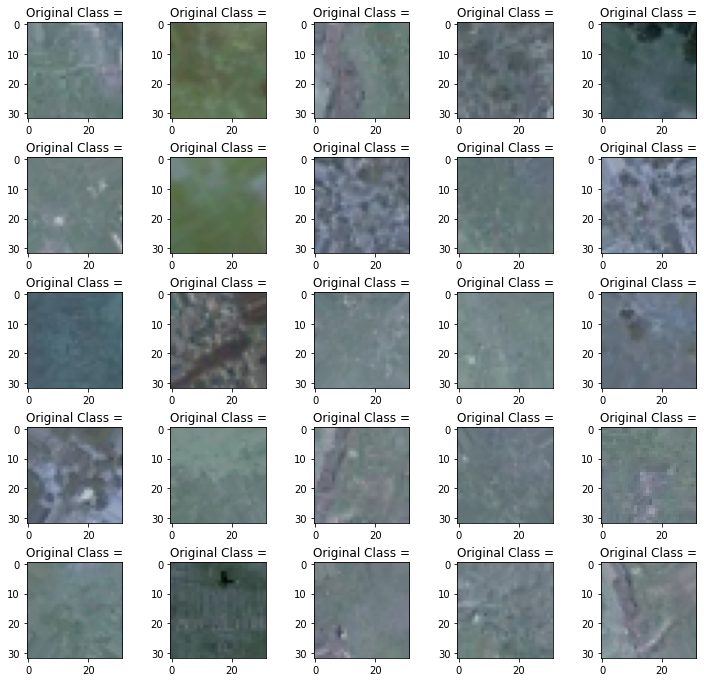

In [68]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title("Prediction Class = ") 
    axes[i].set_title("Original Class =" )
plt.subplots_adjust(wspace=0.5)

# **Listando as redes realmente disponíveis em seu Keras**

In [ ]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **O Modelo pre treinado VGG16**

In [ ]:
# Inicializar a CNN

classifier = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#inp = tf.keras.Input((28,28,3))

In [ ]:
# marcar camadas como não treináveis
for layer in classifier.layers:
    layer.trainable = False

# adicionar novas camadas para classificação

flat1 = tf.keras.layers.Flatten()(classifier.layers[-1].output)
flat1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
flat1 = tf.keras.layers.Dropout(0.5)(flat1)
output = Dense(6, activation='softmax')(flat1)

# definir o modelo
modelvgg16 = Model(inputs=classifier.inputs, outputs=output)

modelvgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
modelvgg16.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksvgg16 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.vgg16',
        save_best_only=True,
        monitor="val_accuracy",
    ),

]

In [ ]:
epochs=200
historyvgg16 = modelvgg16.fit(X_trainVGG16,y_trainVGG16,
                    epochs=epochs,
                    verbose=1,
                    steps_per_epoch = 23999/256,
                    callbacks=callbacksvgg16,
                    validation_data=(X_valVGG16,y_valVGG16))
                    #validation_steps = 5999/64)

Epoch 1/200
93/93 [==============================] - 82s 871ms/step - loss: 1.5390 - accuracy: 0.3828 - val_loss: 0.8826 - val_accuracy: 0.7317
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 2/200
93/93 [==============================] - 82s 882ms/step - loss: 0.9383 - accuracy: 0.6536 - val_loss: 0.6626 - val_accuracy: 0.7739
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 3/200
93/93 [==============================] - 85s 910ms/step - loss: 0.7707 - accuracy: 0.7041 - val_loss: 0.5804 - val_accuracy: 0.7883
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 4/200
93/93 [==============================] - 82s 879ms/step - loss: 0.6755 - accuracy: 0.7419 - val_loss: 0.5232 - val_accuracy: 0.8074
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 5/200
93/93 [==============================] - 91s 973ms/step - loss: 0.6125 - accuracy: 0.7754 - val_loss: 0.4792 - val_accuracy: 0.8374
INFO:tensorf

KeyboardInterrupt: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyvgg16.history['accuracy']
val_acc = historyvgg16.history['val_accuracy']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

In [ ]:
modelvgg16 = tf.keras.models.load_model("feature_extraction.vgg16")

test_lossvgg16, test_accvgg16= modelvgg16.evaluate(X_testVGG16,y_testVGG16)
print("validation_accuracy: " + str(test_accvgg16))

128/128 [==============================] - 40s 312ms/step - loss: 0.2690 - accuracy: 0.8984
validation_accuracy: 0.8984375


# **Comparandos os modelos**

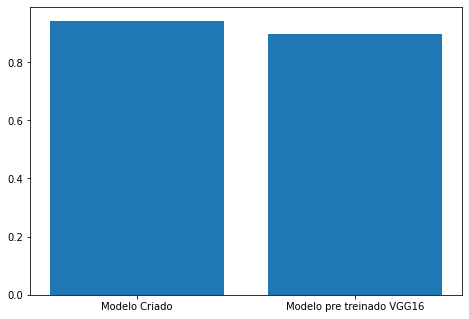

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [test_acc,test_accvgg16]
model = ['Modelo Criado','Modelo pre treinado VGG16']
#model = ['Modelo Criado','VGG16','InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()

# **Realizar a Predição para as 6 classes**